In [2]:
# Using Julia Version 1.0.3
using Distributions
using PyPlot
import Statistics
import StatsBase
using PyCall
using SpecialFunctions
@pyimport pickle

# Goodness-of-fit tests for flexible neutral models

This goodness-of-fit uses the fitted neutral model to simulate a large number of potential datasets from the model, with the exact same covariates structure as the observed data. The test then computes the log-likelihood of these simulated datasets under the fitted model and compares the observed log-likelihood to this distribution.  If the observed log-likelihood differs significantly from the simulated log-likelihoods, then it is unlikely that the model generated the data.

In [4]:
"""
Log-likelihood for the dirchelet-multinomial

Parameters
----------
- x : abundance array
- alphas : dirichlet parameter array

Returns
-------
- log-likelihood of x under model
"""
function dirichlet_multinomial(x, alphas)

    n = sum(x)
    alpha0 = sum(alphas)

    norm_factor = lgamma(n + 1) + lgamma(alpha0) - lgamma(n + alpha0)
    prod_factor = sum(lgamma.(x .+ alphas) .- (lgamma.(x .+ 1.0) .+ lgamma.(alphas)))
    logpdf = norm_factor + prod_factor

    return(logpdf)
end

dirichlet_multinomial

In [5]:
"""
Likelihood for models with selection effects and random effects of OTUs on dispersal and drift

Parameters
----------
- stanfit : Dict from fitted stan object
- standata : Dict used when fitting stan object
- samples : int, number of random datasets to generate

Returns
-------
- Dict
    - full_pred : (N, samples) likelihood for each datapoint in simulated datasets
    - full_obs :  (N, samples) likelihood for each datapoint in observed datasets
    - marg_pred : (S, samples) likelihood for each OTU across samples in simulated datasets
    - marg_obs :  (S, samples) likelihood for each OTU across samples in observed dataset

"""
function model_betabinom(stanfit, standata; samples=500, random_effects=false)
    
    S = standata["S"] # Number of species
    P = standata["P"] # Number of predictor variables for disspersal effects
    X = standata["X"] # Design matrix for dispersal effects
    N = standata["N"] # Number of samples
    G = standata["G"] # Number of random effects (OTU-specific) on dispersal
    Z = standata["Z"] # Design matrix for random OTU-specific effects on dispersal
    
    # Abundance per sample
    Nt_vals = convert(Array{Int64, 1}, round.(standata["Nt"]))
    abund = standata["abund"]

    # Number of samples in posterior
    sim_n = size(stanfit["beta"])[1]
    inds = rand(1:sim_n, samples)

    # Save the results
    full_lik_pred = rand(N, samples)
    full_lik_obs = rand(N, samples)
    marginal_lik_pred = rand(S - 1, samples)
    marginal_lik_obs = rand(S - 1, samples)
    full_ypred = rand(samples, N, S - 1)
    
    if random_effects
        sigmas = stanfit["sigmas"][inds, :]
    else
        sigmas = rand(samples, 1)
    end
    
    for (sid, samp_id) in enumerate(inds)
        
        # Fitted parameters
        meta_p = stanfit["meta_p"][samp_id, :, :]
        
        if random_effects
            β = stanfit["Beta"][samp_id, :, :]
            Ω = stanfit["Omega"][samp_id, :, :]
            I = exp.(X*β + Z*Ω)
        else
            β = try
                    stanfit["Beta"][samp_id, :, :]
                catch
                    β_small = stanfit["beta"][samp_id, :]
                    hcat([β_small for i in 1:(S - 1)]...)
                end
            I = exp.(X*β)
        end
        
        # Simulate data and get likelihood
        y_pred = floor.(Int, rand(N, (S - 1)))
        pred_like = rand(N, (S - 1))
        obs_like = rand(N, (S - 1))

        for s in 1:(S - 1) 

            tbeta = Beta.(I[:, s].*meta_p[:, s], I[:, s].*(1 .- meta_p[:, s]))
            pis = vcat(rand.(tbeta, 1)...)
            ty = vcat(rand.(Binomial.(Nt_vals, pis), 1)...)
            y_pred[:, s] = ty
 
            tpred = rand(N)
            tobs = rand(N)
            for n in 1:N
                α = [I[n, s]*meta_p[n, s], I[n, s]*(1 .- meta_p[n, s])]
                tpred[n] = dirichlet_multinomial([ty[n], Nt_vals[n] - ty[n]], α)
                tobs[n] = dirichlet_multinomial([abund[n, s], Nt_vals[n] - abund[n, s]], α)
            end

            pred_like[:, s] = tpred
            obs_like[:, s] = tobs

        end
        
        full_ypred[sid, :, :] = y_pred
        full_lik_pred[:, sid] = sum(pred_like, dims=2)
        full_lik_obs[:, sid] = sum(obs_like, dims=2)
        marginal_lik_pred[:, sid] = sum(pred_like, dims=1)'
        marginal_lik_obs[:, sid] = sum(obs_like, dims=1)'
    
    end
    
    return(Dict("full_pred"=>full_lik_pred, "full_obs"=>full_lik_obs, 
                "marg_pred"=>marginal_lik_pred, "marg_obs"=>marginal_lik_obs,
                "pred_y"=>full_ypred, "sigmas"=>sigmas))

end


model_betabinom

In [15]:
models = ["mean-lake", "mean-lake-Bd2-int_I-svl-Bd-lake_random-Bd"]

numotus = 19

rand_effects = [false, true]
lik_res = Dict()
for (m, model) in enumerate(models)
    println(model)
    nm = "../results/$model-numOTU$(numotus)_for_julia.pkl"
    fo = open(nm, "r")
    stanfit, standata, X, Z, W, bd_load = pickle.load(fo)
    lik_res["$model"] = model_betabinom(stanfit, standata; samples=500, random_effects=rand_effects[m])
end

mean-lake
mean-lake-Bd2-int_I-svl-Bd-lake_random-Bd


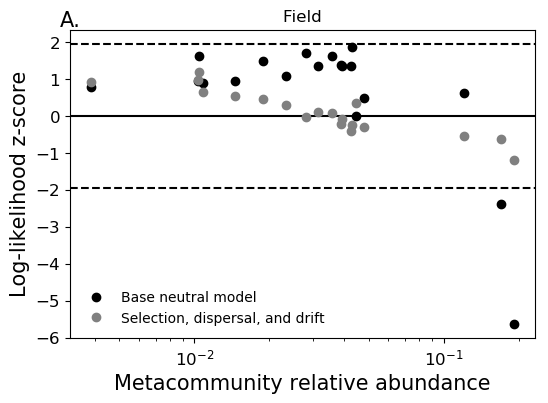

In [22]:
# OTU-Specific GOF

fig, axes = subplots(1, 1, figsize=(6, 4), sharey=true)
axes = [axes]
pretty_names = ["Base neutral model", "Selection, dispersal, and drift"]
likes = [lik_res, lik_res_lab]
modnms = [models, models_lab]
suffix = ["", "_lab"]
letters = ["A.", "B."]
titles = ["Field", "Laboratory"]
colors=["black", "gray"]

for i in 1:1
    
    ax = axes[i]
    
    for (j, modelnm) in enumerate(modnms[i])

        S = size(likes[i]["$modelnm"]["marg_pred"])[1]
        pred_means = mean(likes[i]["$modelnm"]["marg_pred"], dims=2)
        pred_sds = std(likes[i]["$modelnm"]["marg_pred"], dims=2)
        obs_means =  mean(likes[i]["$modelnm"]["marg_obs"], dims=2)
        resid = (obs_means .- pred_means) ./ pred_sds

        # Observed abundance
        suf = suffix[i]
        nm = "../results/base-numOTU$(numotus)$(suf)_for_julia.pkl"
        fo = open(nm, "r")
        stanfit, standata, X, Z, W, bd_load = pickle.load(fo)
        meta_p = vcat(mean(stanfit["meta_p"], dims=(1, 2))...)

        ax[:semilogx](meta_p, resid, marker="o", linestyle="", color=colors[j], label=pretty_names[j])

    end
    
    xlim =  ax[:get_xlim]()
    ax[:hlines](0, xlim...)
    ax[:hlines](1.96, xlim..., linestyle="dashed")
    ax[:hlines](-1.96, xlim..., linestyle="dashed")
    ax[:set_xlabel]("Metacommunity relative abundance", size=15)
    ax[:tick_params](labelsize=12)
    ax[:text](0, 1.01, letters[i], size=15, ha="center", transform=ax[:transAxes])
    ax[:set_title](titles[i], size=12)
    ax[:set_xlim](xlim)
    
    if i == 1
        ax[:legend](loc="lower left", fontsize=10, frameon=false)
        ax[:set_ylabel]("Log-likelihood z-score", size=15)
    end

end

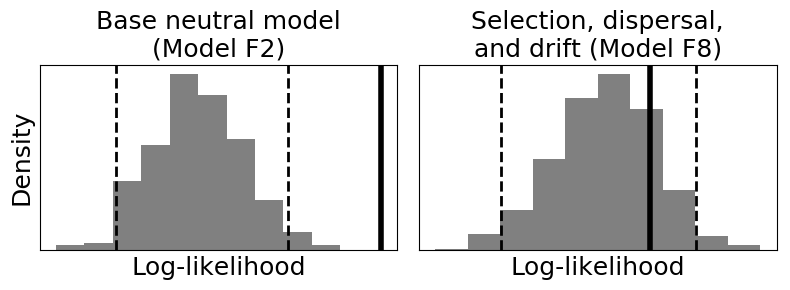

In [23]:
# Datapoint specific GOF

fig, axes = subplots(1, 2, figsize=(8, 3), sharex=false, sharey=false)
pretty_title = ["Base neutral model\n(Model F2)", "Selection, dispersal,\nand drift (Model F8)"]

for (j, modelnm) in enumerate(models)

    pred_like = vcat(sum(lik_res["$modelnm"]["full_pred"], dims=1)...)
    (lower, upper) = Statistics.quantile(pred_like, [.025, .975])
    obs = mean(sum(lik_res["$modelnm"]["full_obs"], dims=1))
    
    ptitle = pretty_title[j]
    axes[j][:hist](pred_like, density=true, color="gray")
    ylim = axes[j][:get_ylim]()
    axes[j][:vlines](obs, ylim..., linewidth=4)
    axes[j][:set_title]("$ptitle", size=18)
    axes[j][:tick_params](labelleft=false, labelbottom=false, bottom=false, left=false)
    axes[j][:set_xlabel]("Log-likelihood", size=18)
    axes[j][:vlines](lower, ylim..., linewidth=2, linestyle="dashed")
    axes[j][:vlines](upper, ylim..., linewidth=2, linestyle="dashed")
    axes[j][:set_ylim](ylim)
    
    if j == 1
        axes[j][:set_ylabel]("Density", size=18)
    end

end

tight_layout()